# Create oceanic boundary condition for regional MITgcm based on SODA3.12.2

In [5]:
import numpy as np
import xarray as xr
import xmitgcm as xm
import os
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
print('===== develop side bcs based on SODA 3.12.2')
vars = ['u', 'v', 'temp', 'salt', 'ssh']
vars1 = ['U', 'V', 'TEMP', 'SALT', 'SSH']
srcdir = './'
mon = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
caseroot = './'

===== develop side bcs based on SODA 3.12.2


In [7]:
# define new grid
runcase = 'NorthPacific.lonlat2x2.42lev'
rname = 'NorthPacific'
xrange = [131, 249]  # zonal extent
yrange = [-16, 62]  # meridional extent
n = [60, 40]   # number of grid points

In [8]:
#define a new grid coordinates
xn = np.linspace(xrange[0], xrange[1], n[0])
yn = np.linspace(yrange[0], yrange[1], n[1])
zn=np.array([-5.0000e+00, -1.5500e+01, -2.7000e+01, -3.9500e+01, -5.3000e+01,
       -6.8000e+01, -8.5000e+01, -1.0400e+02, -1.2550e+02, -1.5000e+02,
       -1.7750e+02, -2.0850e+02, -2.4350e+02, -2.8300e+02, -3.2800e+02,
       -3.7950e+02, -4.3850e+02, -5.0600e+02, -5.8300e+02, -6.7100e+02,
       -7.7200e+02, -8.8800e+02, -1.0210e+03, -1.1735e+03, -1.3485e+03,
       -1.5495e+03, -1.7805e+03, -2.0460e+03, -2.3190e+03, -2.5750e+03,
       -2.8250e+03, -3.0750e+03, -3.3250e+03, -3.5750e+03, -3.8250e+03,
       -4.0750e+03, -4.3250e+03, -4.5750e+03, -4.8250e+03, -5.0750e+03,
       -5.3250e+03, -5.5750e+03], dtype=float) * -1
#
# print the values of x0 and y0
x0 = xn[0]-(xn[1]-xn[0])/2.
y0 = yn[0]-(yn[1]-yn[0])/2.
print('x0='+str(x0))
print('y0='+str(y0))
#
# print the number of grid points in x, y and z
print('Nx='+str(xn.size))
print('Ny='+str(yn.size))
print('Nz='+str(zn.size))

x0=130.0
y0=-17.0
Nx=60
Ny=40
Nz=42


In [11]:
yr=[1990,1991]
vref = [0, 0, 8, 34, 0]
dx = np.diff(xn)
dy = np.diff(yn)
yrI = yr[0]
yrE = yr[-1]
Nt = len(yr) * 12
# initialize array
N=n
tmpE1 = np.zeros((5, Nt, 42, N[1]))
tmpW1 = np.zeros((5, Nt, 42, N[1]))
tmpN1 = np.zeros((5, Nt, 42, N[0]))
tmpS1 = np.zeros((5, Nt, 42, N[0]))

Working on ./soda3.12.2_mn_ocean_reg_1990.nc


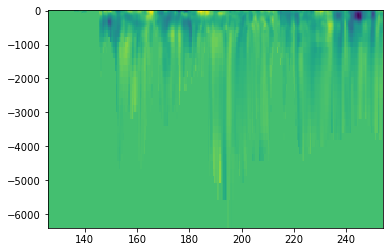

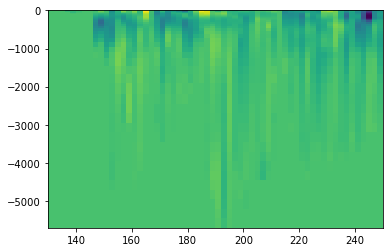

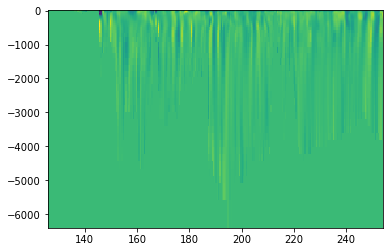

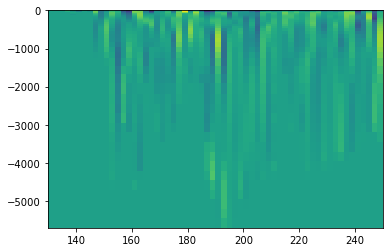

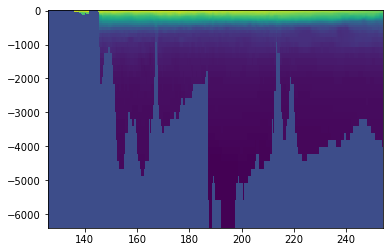

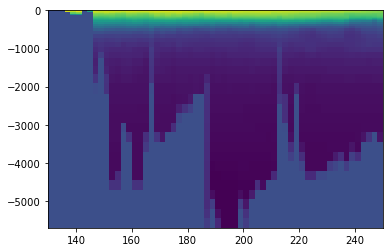

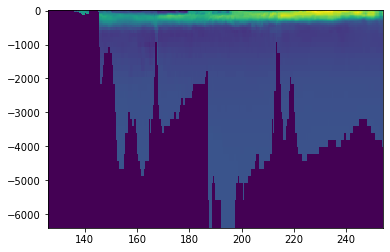

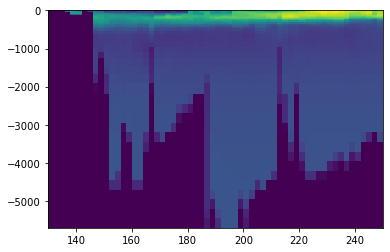

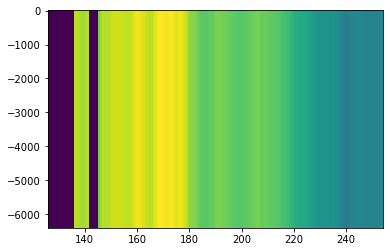

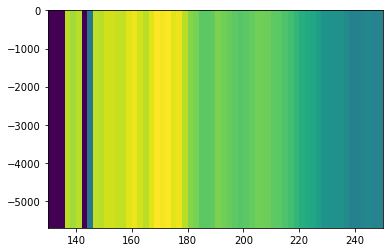

Working on ./soda3.12.2_mn_ocean_reg_1991.nc


In [12]:
# Loop over years
for i, yr0 in enumerate(yr):
    fn = f'{srcdir}soda3.12.2_mn_ocean_reg_{yr0}.nc'
    print(f'Working on {fn}')
    if i == 0:
        x0 = xr.open_dataset(fn).variables['xt_ocean'].values
        y0 = xr.open_dataset(fn).variables['yt_ocean'].values
        z0 = xr.open_dataset(fn).variables['st_ocean'].values
        z0[0] = 0
        z0[-1] = 6000
        I = np.where((x0 >= xn[0]) & (x0 <= xn[-1]))[0]
        J = np.where((y0 >= yn[0]) & (y0 <= yn[-1]))[0]
        Iw = np.where((x0 >= xn[0] - 5) & (x0 <= xn[-1] + 5))[0]
        Jw = np.where((y0 >= yn[0] - 5) & (y0 <= yn[-1] + 5))[0]
    
    # Side boundary condition
    Nz = z0.shape[0]
    for n, var in enumerate(vars):
        tmp0 = xr.open_dataset(fn).variables[var].values
        for m, month in enumerate(mon):
            count = i * 12 + m
            if n == 4:
                tmp1 = tmp0[m, :, :]
                tmp = np.repeat(tmp1[np.newaxis, :, :], Nz, axis=0)
            else:
                tmp= np.squeeze(tmp0[m,:,:,:])
            
            # Eastern boundary
            tmpE = tmp[:, Jw, I[-1]]
            for k in range(len(z0)):
                tmpEk = tmpE[k,:]
                tmpEkm = np.nanmean(tmpEk,axis=0)
                tmpEk[np.isnan(tmpEk)] = vref[n]
                tmpE[k, :] = tmpEk
            tmpmap = RectBivariateSpline(z0, y0[Jw], tmpE, kx=1, ky=1)
            tmpE1[n, count, :, :] =  tmpmap(zn, yn)
            
            # Western boundary
            tmpW = tmp[:, Jw, I[0]]
            for k in range(len(z0)):
                tmpWk = tmpW[k,:]
                tmpWkm = np.nanmean(tmpWk,axis=0)
                tmpWk[np.isnan(tmpWk)] = vref[n]
                tmpW[k, :] = tmpWk
            tmpmap = RectBivariateSpline(z0, y0[Jw],tmpW, kx=1, ky=1)
            tmpW1[n, count, :, :] =  tmpmap(zn, yn)
            
            # Northern boundary
            tmpN = tmp[:, J[-1], Iw]
            for k in range(len(z0)):
                tmpNk = tmpN[k,:]
                tmpNkm = np.nanmean(tmpNk,axis=0)
                tmpNk[np.isnan(tmpNk)] = vref[n]
                tmpN[k, :] = tmpNk
            tmpmap = RectBivariateSpline(z0, x0[Iw],tmpN, kx=1, ky=1)
            tmpN1[n, count, :, :] =  tmpmap(zn, xn)
            
            # Southern boundary
            tmpS = tmp[:, J[0], Iw]
            for k in range(len(z0)):
                tmpSk = tmpS[k,:]
                tmpSkm = np.nanmean(tmpSk,axis=0)
                tmpSk[np.isnan(tmpSk)] = vref[n]
                tmpS[k, :] = tmpSk
            tmpmap = RectBivariateSpline(z0, x0[Iw],tmpS, kx=1, ky=1)
            tmpS1[n, count, :, :] =  tmpmap(zn, xn)
            
            if count == 0:
                plt.pcolormesh(x0[Iw], -z0, tmpS)
                plt.show()
                plt.pcolormesh(xn, -zn, tmpS1[n,count,:,:])
                plt.show()

In [13]:
# Manual switch
# Set to 1 if it is RYF
RYF=1
#
for n, var in enumerate(vars):
    # East
    fn = f'{caseroot}/SODA3122_{var}_east_{yrI}_{yrE}.bin'
    print(fn)
    if n==4:
        if RYF==1:
            xm.utils.write_to_binary(tmpE1[n,4:16,0,:].flatten(), fn)
        else:
            xm.utils.write_to_binary(tmpE1[n,:,0,:].flatten(), fn)
    else:
        if RYF==1:
            xm.utils.write_to_binary(tmpE1[n,4:16,:,:].flatten(), fn)
        else:
            xm.utils.write_to_binary(tmpE1[n,:,:,:].flatten(), fn)
    # West
    fn = f'{caseroot}/SODA3122_{var}_west_{yrI}_{yrE}.bin'
    print(fn)
    if n==4:
        if RYF==1:
            xm.utils.write_to_binary(tmpW1[n,4:16,0,:].flatten(), fn)
        else:
            xm.utils.write_to_binary(tmpW1[n,:,0,:].flatten(), fn)
    else:
        if RYF==1:
            xm.utils.write_to_binary(tmpW1[n,4:16,:,:].flatten(), fn)
        else:
            xm.utils.write_to_binary(tmpW1[n,:,:,:].flatten(), fn)
    # North
    fn = f'{caseroot}/SODA3122_{var}_north_{yrI}_{yrE}.bin'
    print(fn)
    if n==4:
        if RYF==1:
            xm.utils.write_to_binary(tmpN1[n,4:16,0,:].flatten(), fn)
        else:
            xm.utils.write_to_binary(tmpN1[n,:,0,:].flatten(), fn)
    else:
        if RYF==1:
            xm.utils.write_to_binary(tmpN1[n,4:16,:,:].flatten(), fn)
        else:
            xm.utils.write_to_binary(tmpN1[n,:,:,:].flatten(), fn)
    # South
    fn = f'{caseroot}/SODA3122_{var}_south_{yrI}_{yrE}.bin'
    print(fn)
    if n==4:
        if RYF==1:
            xm.utils.write_to_binary(tmpS1[n,4:16,0,:].flatten(), fn)
        else:
            xm.utils.write_to_binary(tmpS1[n,:,0,:].flatten(), fn)
    else:
        if RYF==1:
            xm.utils.write_to_binary(tmpS1[n,4:16,:,:].flatten(), fn)
        else:
            xm.utils.write_to_binary(tmpS1[n,:,:,:].flatten(), fn)


.//SODA3122_u_east_1990_1991.bin
.//SODA3122_u_west_1990_1991.bin
.//SODA3122_u_north_1990_1991.bin
.//SODA3122_u_south_1990_1991.bin
.//SODA3122_v_east_1990_1991.bin
.//SODA3122_v_west_1990_1991.bin
.//SODA3122_v_north_1990_1991.bin
.//SODA3122_v_south_1990_1991.bin
.//SODA3122_temp_east_1990_1991.bin
.//SODA3122_temp_west_1990_1991.bin
.//SODA3122_temp_north_1990_1991.bin
.//SODA3122_temp_south_1990_1991.bin
.//SODA3122_salt_east_1990_1991.bin
.//SODA3122_salt_west_1990_1991.bin
.//SODA3122_salt_north_1990_1991.bin
.//SODA3122_salt_south_1990_1991.bin
.//SODA3122_ssh_east_1990_1991.bin
.//SODA3122_ssh_west_1990_1991.bin
.//SODA3122_ssh_north_1990_1991.bin
.//SODA3122_ssh_south_1990_1991.bin
